Extract Job Description Keyword to improve DS resume...

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

jd_data = pd.read_csv("/content/drive/MyDrive/data/jd_data_20240929.csv")

In [ ]:
jd_data.head()

,company,jd
0,tiktok,About the Team\nTikTok's Data Cycling Center T...
1,tiktok,TikTok-Data Science team is responsible for al...
2,tiktok,We're the TikTok Monetization Products data sc...
3,tiktok,We're the TikTok Monetization Products data sc...
4,tiktok,About the Team\nOur Data Science team is respo...


# Extract Keyword

In [ ]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import pandas as pd

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load spaCy model for NLP
nlp = spacy.load('en_core_web_sm')

# Function to clean, lemmatize, and remove stopwords
def clean_and_lemmatize(text, custom_stopwords=None, words_to_keep=None):
    # Load default NLTK stopwords
    stop_words = set(stopwords.words('english'))

    # Add custom stopwords (if any)
    if custom_stopwords:
        stop_words.update(custom_stopwords)

    # Define words to keep in original form
    if words_to_keep is None:
        words_to_keep = []

    # Remove non-alphabetical characters and convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = text.lower().strip()

    # Lemmatize the text using spaCy
    doc = nlp(text)

    # Get lemmas (root forms) first
    lemmatized_text = []
    for token in doc:
        if token.is_punct:
            continue
        # Keep the original form if it's in the words_to_keep list
        if token.text in words_to_keep:
            lemmatized_text.append(token.text)  # Keep the original token
        else:
            lemmatized_text.append(token.lemma_)  # Append the lemmatized form

    # Remove stopwords (after lemmatization)
    cleaned_text = ' '.join([word for word in lemmatized_text if word not in stop_words])

    return cleaned_text

# Function to extract keywords using TF-IDF
def extract_keywords(job_descriptions, num_keywords=10):
    """
    job_descriptions are in list format with text in string format
    """
    # Define custom stopwords
    my_custom_stopwords = ['experience', 'team', 'science', 'quantitative',
                           'qualification', 'work', 'tiktok', 'eg',
                           'user', 'ability', 'year',
                           'bachelor', 'degree', 'data',
                           'analysis', 'mining', 'use', 'uber', 'strong',
                           'scientist', 'role', 'skill']

    # Define words to keep in original form
    words_to_keep = ['data']

    # Clean and preprocess the job description text
    job_descriptions_cleaned = [clean_and_lemmatize(text, my_custom_stopwords, words_to_keep) for text in job_descriptions]

    # Use TF-IDF Vectorizer to convert text data into numeric format
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Extract unigrams and bigrams
    tfidf_matrix = vectorizer.fit_transform(job_descriptions_cleaned)

    # Get feature names (i.e., the words)
    feature_names = vectorizer.get_feature_names_out()

    # Compute average score for each term
    avg_scores = tfidf_matrix.mean(axis=0).tolist()[0]

    # Create a dataframe of words and their average scores
    keyword_scores = pd.DataFrame({'keyword': feature_names, 'score': avg_scores})

    # Split into unigrams and bigrams
    unigrams = keyword_scores[keyword_scores['keyword'].str.split().str.len() == 1]
    bigrams = keyword_scores[keyword_scores['keyword'].str.split().str.len() == 2]

    # Sort the keywords by score in descending order
    unigrams_sorted = unigrams.sort_values(by='score', ascending=False).head(num_keywords)

    # Create a dictionary for aggregated bigrams
    aggregated_bigrams = {}

    # Define groups of bigrams to aggregate
    bigram_groups = {
        "machine learning": ["machine learn", "machine learning"],
        "ab test": ["ab test", "ab testing"],
    }

    # Aggregate scores
    for index, row in bigrams.iterrows():
        bigram = row['keyword']
        score = row['score']

        # Check if the bigram is part of any aggregation group
        combined_key = None
        for key, values in bigram_groups.items():
            if bigram in values:
                combined_key = key
                break

        # If it belongs to a group, aggregate the score
        if combined_key:
            if combined_key in aggregated_bigrams:
                aggregated_bigrams[combined_key] += score
            else:
                aggregated_bigrams[combined_key] = score
        else:
            # If it's not part of a group, just add it as is
            aggregated_bigrams[bigram] = aggregated_bigrams.get(bigram, 0) + score

    # Convert aggregated bigrams to a DataFrame
    aggregated_bigrams_df = pd.DataFrame(list(aggregated_bigrams.items()), columns=['keyword', 'score'])

    # Sort the aggregated bigrams by score
    bigrams_sorted = aggregated_bigrams_df.sort_values(by='score', ascending=False).head(num_keywords)

    # Exclude specific bigrams
    unwanted_bigrams = ['bachelor degree', 'data scientist', 'data analysis', 'data mining']
    bigrams_sorted = bigrams_sorted[~bigrams_sorted['keyword'].isin(unwanted_bigrams)]

    return unigrams_sorted, bigrams_sorted

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Extract top keywords
top_unigrams, top_bigrams = extract_keywords(jd_data['jd'].tolist(), num_keywords=30)

# Show the top unigrams and bigrams
print("Top Unigrams:")
print(top_unigrams)

print("\nTop Bigrams:")
print(top_bigrams)

Top Unigrams:
         keyword     score
730      product  0.123557
95      business  0.073738
397       growth  0.050703
622        model  0.046534
254        drive  0.046322
86         build  0.045550
220       design  0.044526
469      insight  0.043204
264    ecommerce  0.038902
433      improve  0.038076
603       metric  0.037074
872     solution  0.036699
547      machine  0.036255
14            ad  0.035682
887    statistic  0.035086
39      analytic  0.035012
931    technical  0.034461
207     decision  0.034271
232      develop  0.034175
894  statistical  0.034091
903     strategy  0.033584
657  opportunity  0.031986
298  engineering  0.031749
421     identify  0.031442
971   understand  0.030679
726      problem  0.030514
766      provide  0.030022
442      include  0.029953
568    marketing  0.028900
351        field  0.028595

Top Bigrams:
                     keyword     score
232         machine learning  0.044284
0                    ab test  0.029454
53          causal

# Visualize the Output


*   use wordcloud
*   rank font size ordered by importance



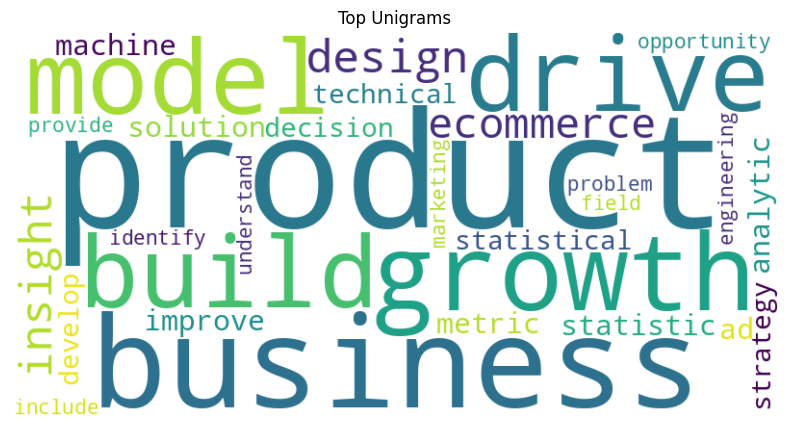

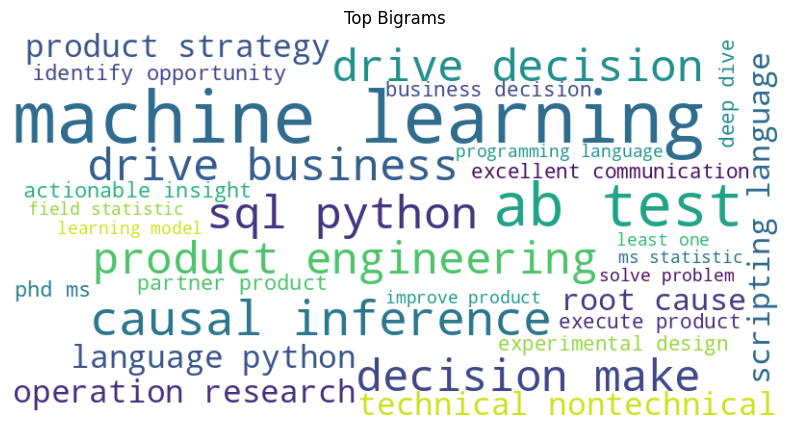

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(data, title):
    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(data)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example usage for unigrams and bigrams
plot_word_cloud(dict(zip(top_unigrams['keyword'], top_unigrams['score'])), "Top Unigrams")
plot_word_cloud(dict(zip(top_bigrams['keyword'], top_bigrams['score'])), "Top Bigrams")


# Improvement


*   try using GPT to summarize?
*   get more latest job description data

